In [198]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split

lmodel = LinearRegression()

# Read in CSV's to pandas
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train_labels = train["SalePrice"]

model_data = pd.concat([train,test],ignore_index=True)
model_data = model_data.drop("SalePrice", 1)

In [199]:
########## KMeans to modify nan values ##########
########## inputs:
########## label of col to update, indices in that col that have nan value,
########## data for clustering (including nan col), k number of clusters

########## output:
########## dictionary of {index : new value to replace nan}
def KMeans_nan_replacement(nan_col_label, nan_indices, k_data, k):

    # first iteration of KMeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(k_data)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    prev_labels = []
    converged = False

    # Run KMeans, update previously nan values to converge on their centroids,
    # Until the clusters stop changing
    while(converged == False):
        for nan_index in nan_indices:
            # Set LotFrontage value that was previously nan to
            # centroid for the k_data point at that same index
            k_data.loc(nan_index)[0]["LotFrontage"] = centroids[labels[nan_index]][0]

        # Rerun KMeans
        kmeans = KMeans(n_clusters=k, random_state=0).fit(k_data)
        # Store new labels
        labels = kmeans.labels_
        
        # If labels did not change in this run, algorithm has converged
        # (is this error prone if the window of distance to centroid is large?)
        if np.all(labels == prev_labels):
            converged = True

        prev_labels = labels

    # Return a dict of {index : new value}
    return dict(zip(nan_indices, [k_data[nan_col_label][i] for i in [nan_indices]]))
##############################

In [200]:
def test_regression_model(regression_model, training_data, training_labels, test_data, test_labels):
    # Train Model
    regression_model.fit(training_data, training_labels)
    # Predict test data
    results = regression_model.predict(test_data)
    # return RMSE from test labels, and the results
    return [math.sqrt(mean_squared_error(test_labels, results)), results]

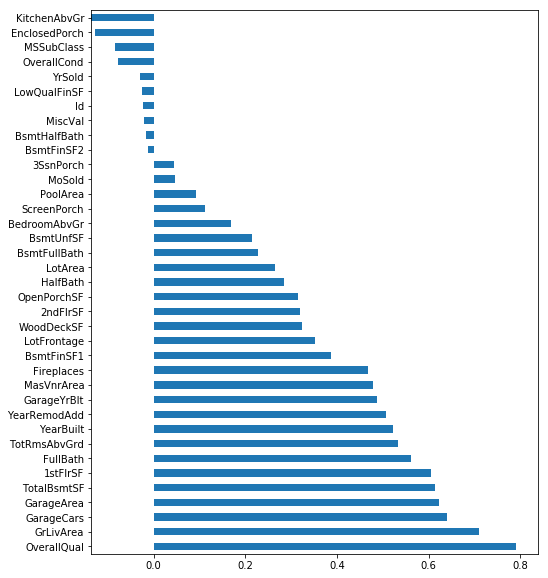

In [201]:
# Correlations of train column to SalePrice with numerical data
corrs = train.corr()["SalePrice"]
corrs = corrs.sort_values(ascending=False)[1:] # Sort from highest to lowest correlation, removing the top one (SalePrice)
plt.rcParams['figure.figsize'] = (8.0, 10.0)
corrs.plot(kind = "barh")

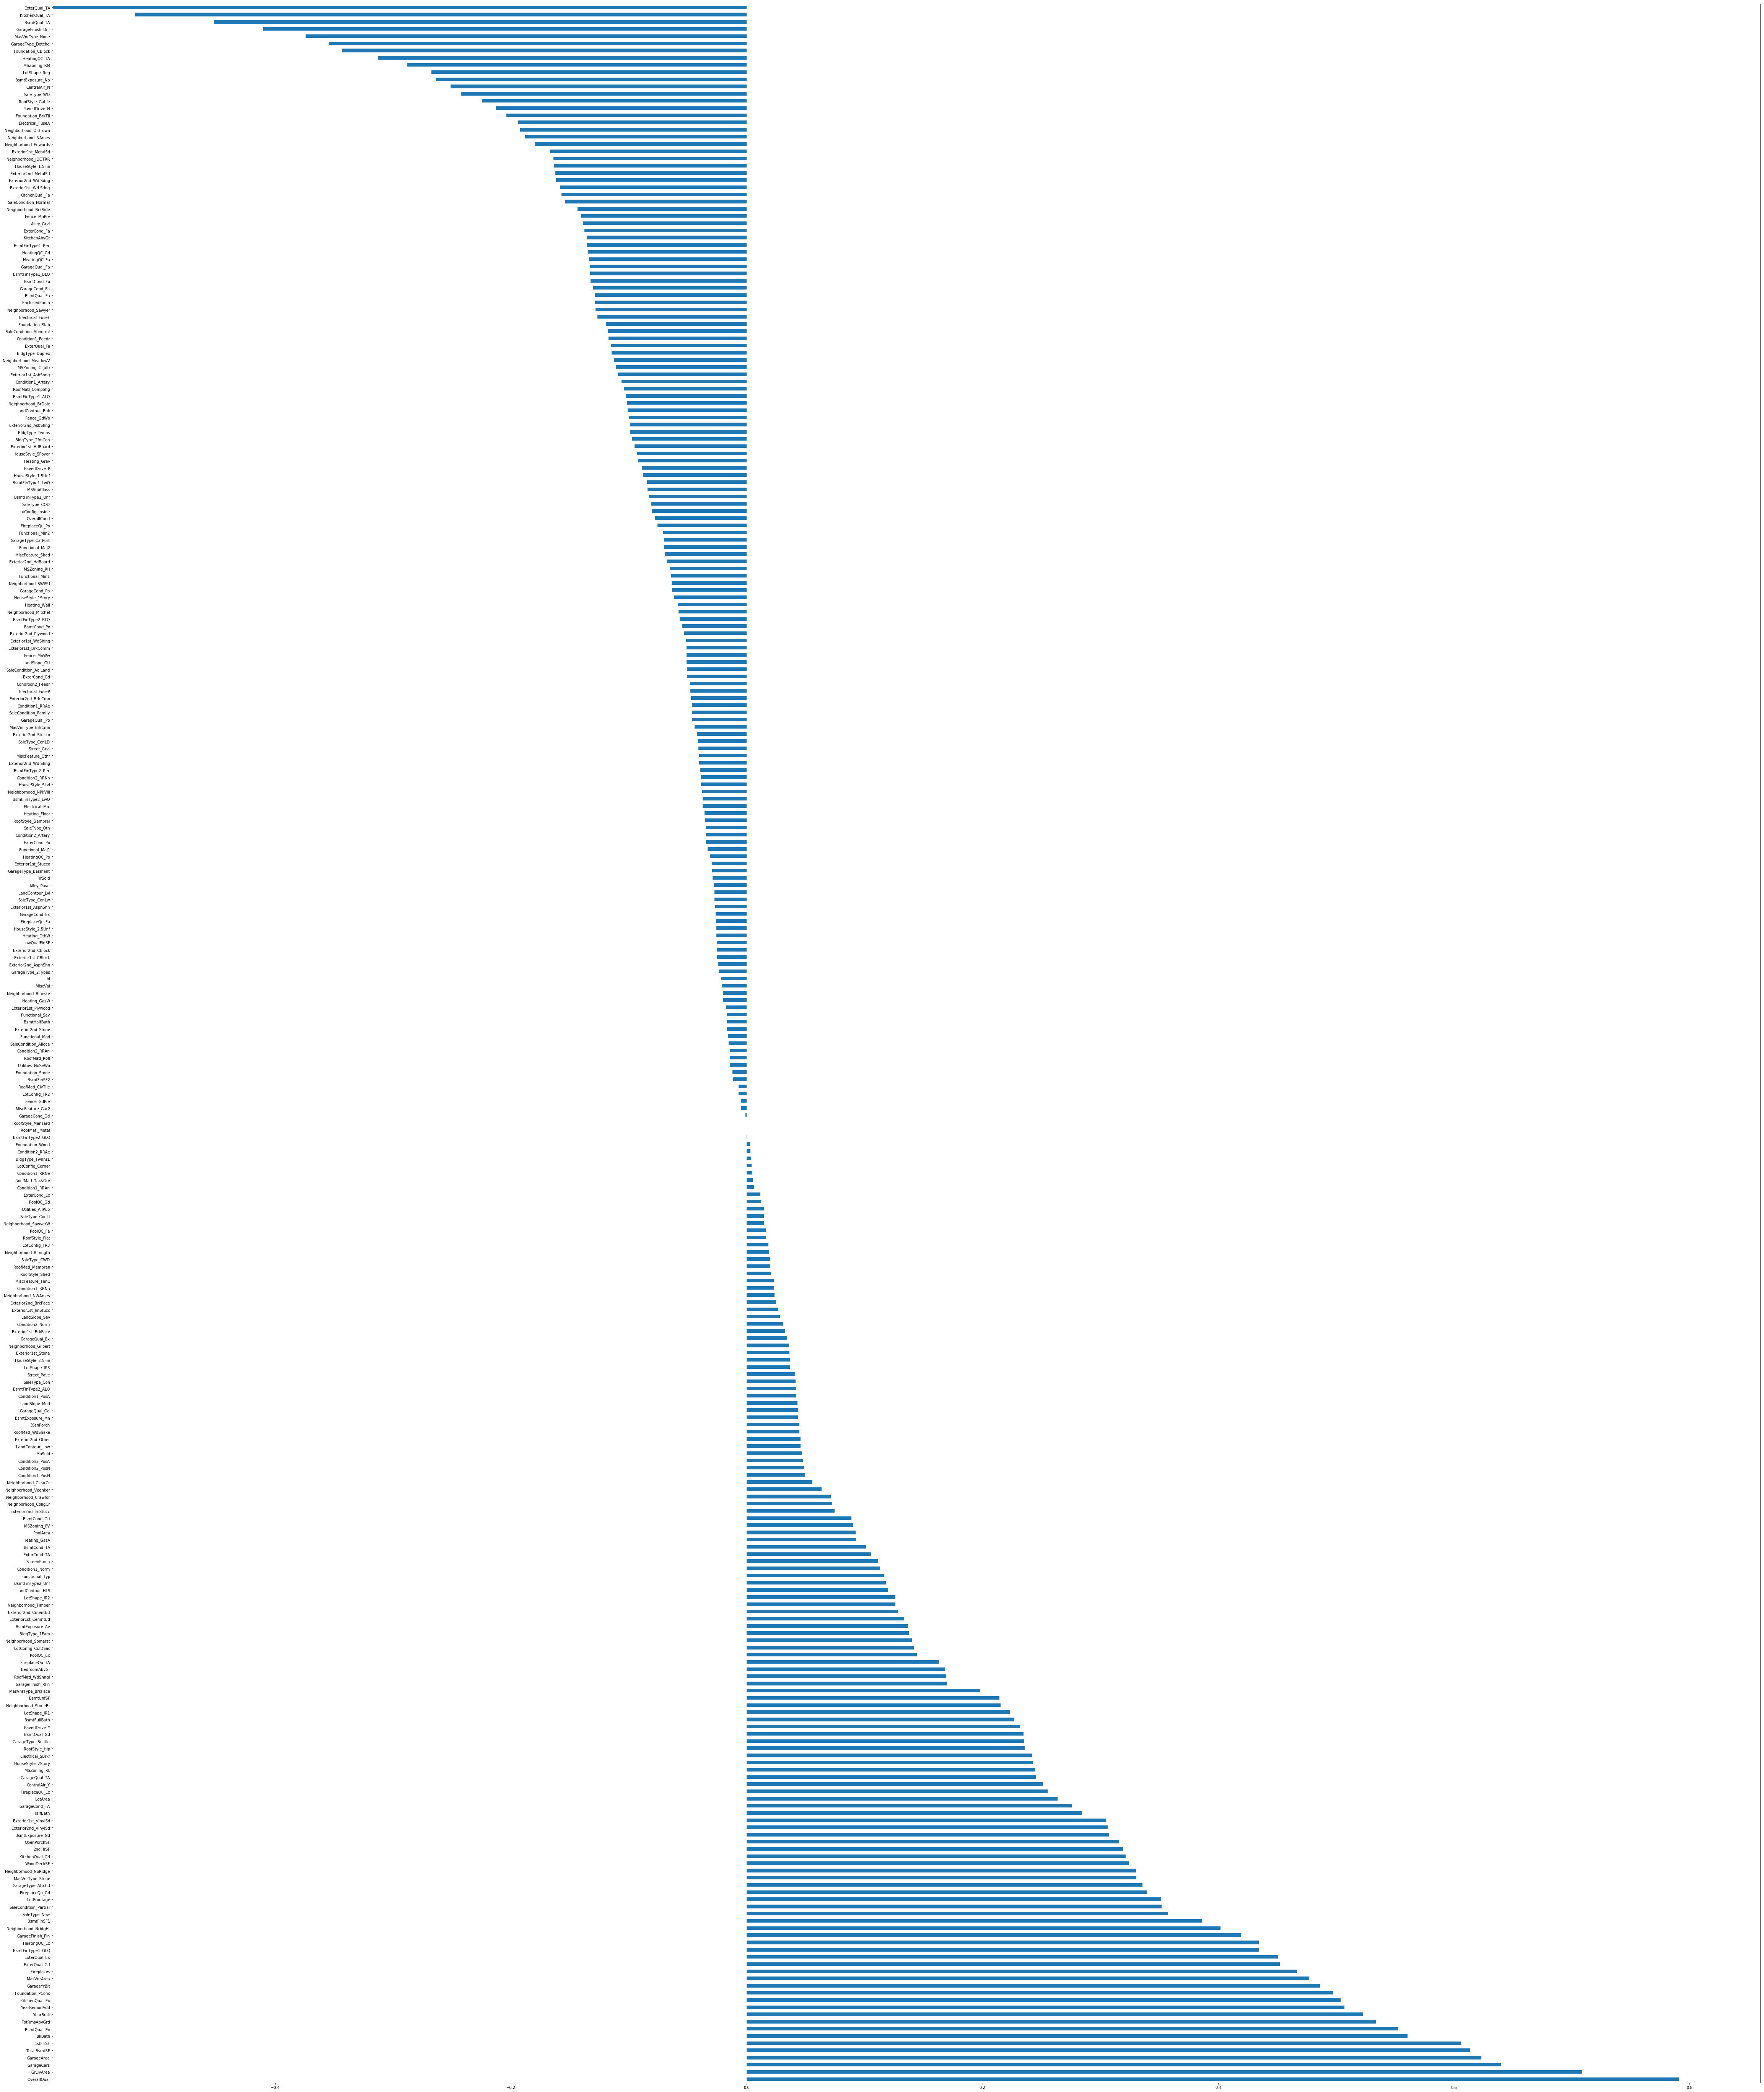

In [83]:
# Use get dummies to get one-hot vectors for categorical features
# Try correlations again
corrs = pd.get_dummies(train).corr()["SalePrice"]
corrs = corrs.sort_values(ascending=False)[1:] # Sort from highest to lowest correlation, removing the top one (SalePrice)
plt.rcParams['figure.figsize'] = (80.0, 100.0)
corrs.plot(kind = "barh")

# Fuck this, too many cols after get_dummies, only worry about nan in numerical features

In [202]:
# one-hot vector for categorical features
model_data = pd.get_dummies(model_data)

# Find cols with nan
all_nan_cols = model_data.columns[pd.isnull(model_data).any()].tolist()
print all_nan_cols

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF']


In [203]:
# Iterate over all NAN cols, try to apply KMeans for value replacement
# Test if it positively affects regression model
# If so, keep it, if not, get rid of the feature.
for col in all_nan_cols:
    print "########%s########" % col
    # Get the nan_indices of current col
    col_nan_indices = model_data[col].index[model_data[col].apply(np.isnan)]
    # Set all nan cols to col mean
    k_data = model_data.fillna(model_data.mean())
    # Run KMeans to fill nan for LotFrontage
    col_indices_and_new_values = KMeans_nan_replacement(col, col_nan_indices, k_data, 9)
    # Put the new values to replace nan into our model data
    for index, value in col_indices_and_new_values.iteritems():
        model_data[col][index] = value
        
    # Train model and check current sum square error with this data
    # Get the training data from model_data
    training_data = model_data[:train.shape[0]]
    training_data = training_data.fillna(training_data.mean())
    print training_data.columns[pd.isnull(training_data).any()].tolist()
    training_data["SalePrice"] = train_labels
    train, test = train_test_split(training_data, test_size = 0.2)
    # Set values for testing model
    train_labels = np.log(train["SalePrice"])
    test_labels =  np.log(test["SalePrice"])
    print train_labels
    print test_labels
    train = train.drop("SalePrice", axis = 1)
    test = test.drop("SalePrice", axis = 1)
    res = test_regression_model(lmodel, train, train_labels, test, test_labels)
    print res[0]

########BsmtFinSF1########


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[]
0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, dtype: int64
622          NaN
127     2.431300
291     2.469765
7

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').